In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class MazeGame:
    def __init__(self):
        maze_layout = [[1, 1, 1, 1, 1, 1, 1],
               [1, 0, 0, 0, 0, 0, 1],
               [1, 0, 1, 1, 1, 0, 1],
               [1, 0, 1, 0, 0, 0, 1],
               [1, 0, 1, 1, 1, 1, 1],
               [1, 0, 0, 0, 0, 0, 0],
               [1, 1, 1, 1, 1, 1, 1]]
        """Initialize the maze game with a given layout."""
        self.layout = np.array(maze_layout)
        self.rgb_maze = self._to_rgb()
        self.start_pos = None
        self.exit_pos = None
        self.current_pos = None

    def _to_rgb(self):
        """Convert the maze layout to an RGB image."""
        rgb = np.zeros((*self.layout.shape, 3))  # Create a new RGB array
        for i in range(3):  # Copy the grayscale values into each RGB channel
            rgb[:, :, i] = 1 - self.layout
        return rgb

    def initialPosition(self, row, col):
        """Set the initial position in the maze."""
        if self.layout[row, col] == 0:
            self.start_pos = (row, col)
            self.current_pos = (row, col)
            self.set_point(row, col, [0, 0, 1])  # Mark initial position with blue
        else:
            print("Invalid initial position: It is on a wall.")

    def setExit(self, row, col):
        """Set the exit position in the maze."""
        if self.layout[row, col] == 0:
            self.exit_pos = (row, col)
            self.set_point(row, col, [0, 1, 0])  # Mark exit position with green
        else:
            print("Invalid exit position: It is on a wall.")

    def set_point(self, row, col, color):
        """Set a specific point in the maze to a given color."""
        self.rgb_maze[row, col] = color

    def makeMove(self, direction):
        """Attempt to move in the specified direction."""
        if self.current_pos is None:
            print("Initial position not set.")
            return 0

        row, col = self.current_pos
        if direction == "up":
            new_pos = (row - 1, col)
        elif direction == "down":
            new_pos = (row + 1, col)
        elif direction == "left":
            new_pos = (row, col - 1)
        elif direction == "right":
            new_pos = (row, col + 1)
        else:
            print("Invalid direction.")
            return 0

        if self.isValidMove(new_pos):
            self.current_pos = new_pos
            self.set_point(*self.start_pos, [1 - self.layout[self.start_pos]])  # Reset start position color
            self.start_pos = new_pos
            self.set_point(*new_pos, [0, 0, 1])  # Mark new position with blue
            if self.current_pos == self.exit_pos:
                # print("Success! You've found the way out.")
                return 1
        # else:
        #    print("Invalid move: Can't move through walls or out of bounds.")

    def isValidMove(self, pos):
        """Check if a move is valid (within bounds and not through walls)."""
        row, col = pos
        if 0 <= row < self.layout.shape[0] and 0 <= col < self.layout.shape[1]:
            return self.layout[row, col] == 0
        return False

    def plot(self):
        """Plot the maze."""
        plt.figure(figsize=(7, 7))
        plt.imshow(self.rgb_maze, interpolation='nearest')
        plt.xticks([]), plt.yticks([])  # Hide axes ticks
        plt.show()

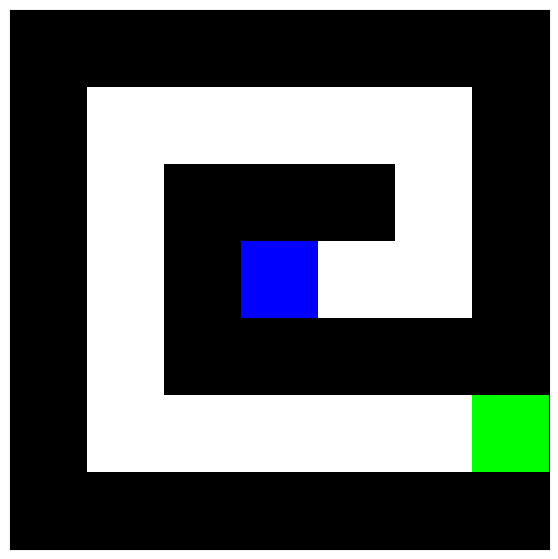

In [3]:
# Create an instance of MazeGame
maze_game = MazeGame()

# Set the initial and exit positions
maze_game.initialPosition(3, 3)
maze_game.setExit(5, 6)
maze_game.plot()

Model-free RL agent

In [4]:
class QLearningAgent:
    def __init__(self, game, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.game = game
        self.q_table = np.zeros((game.layout.size, 4))  # 4 actions: up, down, left, right
        # print('At initialization, the Q table is given as,', self.q_table)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = ['up', 'down', 'left', 'right']

    def state_to_index(self, state):
        """Converts a 2D state to a 1D index for the Q-table."""
        # print('Given state at,', state)
        # print('The index is given as,', state[0] * self.game.layout.shape[1] + state[1])
        return state[0] * self.game.layout.shape[1] + state[1]

    def choose_action(self, state_index):
        """Choose action based on ε-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)  # Explore
        else:
            # print('exploit action at,', np.argmax(self.q_table[state_index]))
            return self.actions[np.argmax(self.q_table[state_index])]  # Exploit

    def learn(self, state, action, reward, next_state):
        """Update the Q-value using the Q-learning formula."""
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        action_index = self.actions.index(action)
        next_max = np.max(self.q_table[next_state_index])

        # Q-learning formula
        self.q_table[state_index, action_index] = self.q_table[state_index, action_index] + \
            self.alpha * (reward + self.gamma * next_max - self.q_table[state_index, action_index])
        # print('Update Q table,', self.q_table)

    def train(self, episodes=1000, print_out_internal_variable=False):
        for episode in range(episodes):
            self.game.initialPosition(3, 3)  # Reset to starting position
            state = self.game.current_pos
            steps = 0
            success = 0
            while not success and steps < 50:
                # Select and perform an action
                action = self.choose_action(self.state_to_index(state))
                old_state = state
                success = self.game.makeMove(action)
                state = self.game.current_pos

                # Extremely important note here: There are generally two ways that we could design out Q learner here
                # First, we could use memory reply and only update the Q table if the agent has reached the exit at
                # the end. In this case, the actions of the agent is imagined as all the possible action trajectories
                # of the agent. I personally believe that this supposedly is the correct way to build the agent.
                # However, there is another way to build the agent. That we encode each pixel as a possible state.
                # Then, each state has 4 possible actions. We build a 4 by 49 matrix. An action would lead to a
                # punishment, if the agent does not move. That means, moving towards a wall would lead to negative
                # rewards. In this way, we could deal away with the high-dimensionality of the action trajectory space.
                # However, technically, we don't have a sparse reward signal for our Q learning agent. Instead,
                # we have a very dense rewarded-punished Q learning agent.
                #
                # Nevertheless, given this really hacked trick, the Q learning agent still takes many episodes to
                # finally actually learned how to navigate out of the maze.

                # Specifically, we reward if the agent reaches the exit, and punishes if the agent does not move.
                # reward = 1 if success else -0.001  # Simple reward: -0.5 for each step, +1 for reaching the goal

                # we implement with actual sparse reward
                reward = 1 if success else 0  # Simple reward: +1 for reaching the goal

                # Learn from the transition
                self.learn(old_state, action, reward, state)
                steps += 1
            if print_out_internal_variable:
                print(f"Episode {episode}: the agent took {steps} steps.")
                print('Current Q table,', self.q_table)
                print('The agent reaches the exit or not?', success)
            if episode % 10000 == 0:
                print(f"in Episode {episode}: the agent completed in {steps} steps.")
            if success:
                print(f"in Episode {episode}: the agent completed in {steps} steps.")

Train Agent

In [5]:
agent = QLearningAgent(maze_game)
agent.train(100000, False)

in Episode 0: the agent completed in 50 steps.
in Episode 10000: the agent completed in 50 steps.
in Episode 20000: the agent completed in 50 steps.
in Episode 30000: the agent completed in 50 steps.
in Episode 40000: the agent completed in 50 steps.
in Episode 50000: the agent completed in 50 steps.
in Episode 60000: the agent completed in 50 steps.
in Episode 70000: the agent completed in 50 steps.
in Episode 80000: the agent completed in 50 steps.
in Episode 90000: the agent completed in 50 steps.


Test Agent

Starting test from position: (3, 3)
Step 1: Moved up, New position: (3, 3)
Step 2: Moved up, New position: (3, 3)
Step 3: Moved up, New position: (3, 3)
Step 4: Moved up, New position: (3, 3)
Step 5: Moved up, New position: (3, 3)
Step 6: Moved up, New position: (3, 3)
Step 7: Moved up, New position: (3, 3)
Step 8: Moved up, New position: (3, 3)
Step 9: Moved up, New position: (3, 3)
Step 10: Moved up, New position: (3, 3)
Step 11: Moved up, New position: (3, 3)
Step 12: Moved up, New position: (3, 3)
Step 13: Moved up, New position: (3, 3)
Step 14: Moved up, New position: (3, 3)
Step 15: Moved up, New position: (3, 3)
Step 16: Moved up, New position: (3, 3)
Step 17: Moved up, New position: (3, 3)
Step 18: Moved up, New position: (3, 3)
Step 19: Moved up, New position: (3, 3)
Step 20: Moved up, New position: (3, 3)
Step 21: Moved up, New position: (3, 3)
Step 22: Moved up, New position: (3, 3)
Step 23: Moved up, New position: (3, 3)
Step 24: Moved up, New position: (3, 3)
Step 25: Move

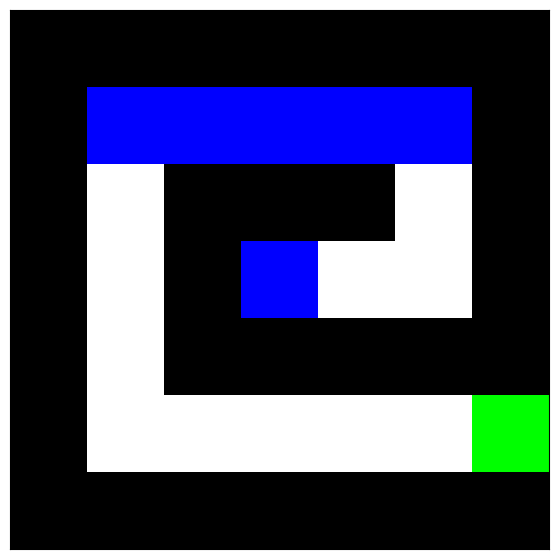

In [6]:
def test_agent(agent, game, max_steps=50):
    game.initialPosition(3, 3)  # Reset to starting position
    state = game.current_pos
    steps = 0
    success = False
    # Display the initial state of the maze
    # game.plot()
    print(f"Starting test from position: {state}")
    while not success and steps < max_steps:
        state_index = agent.state_to_index(state)
        action = agent.actions[np.argmax(agent.q_table[state_index])]  # Choose best action
        success = game.makeMove(action)  # Perform the action
        state = game.current_pos  # Update state
        steps += 1
        print(f"Step {steps}: Moved {action}, New position: {state}")
    if success:
        print("Success! The agent found the way out.")
    else:
        print("Failed to find the way out within the maximum allowed steps.")

    # Display the final state of the maze
    game.plot()
# Now, let's test the trained agent.
test_agent(agent, maze_game)

Model-free RL agent with noisy punishment for not moving

In [7]:
class QLearningAgent_with_noisy_punishment:
    def __init__(self, game, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.game = game
        self.q_table = np.zeros((game.layout.size, 4))  # 4 actions: up, down, left, right
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = ['up', 'down', 'left', 'right']

    def state_to_index(self, state):
        """Converts a 2D state to a 1D index for the Q-table."""
        return state[0] * self.game.layout.shape[1] + state[1]

    def choose_action(self, state_index):
        """Choose action based on ε-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)  # Explore
        else:
            return self.actions[np.argmax(self.q_table[state_index])]  # Exploit

    def learn(self, state, action, reward, next_state):
        """Update the Q-value using the Q-learning formula."""
        state_index = self.state_to_index(state)
        next_state_index = self.state_to_index(next_state)
        action_index = self.actions.index(action)
        next_max = np.max(self.q_table[next_state_index])
        self.q_table[state_index, action_index] = self.q_table[state_index, action_index] + \
            self.alpha * (reward + self.gamma * next_max - self.q_table[state_index, action_index])

    def train(self, episodes=1000, print_out_internal_variable=False):
        for episode in range(episodes):
            self.game.initialPosition(3, 3)  # Reset to starting position
            state = self.game.current_pos
            steps = 0
            success = 0
            while not success and steps < 50:
                action = self.choose_action(self.state_to_index(state))
                old_state = state
                success = self.game.makeMove(action)
                state = self.game.current_pos

                # Extremely important note here: There are generally two ways that we could design out Q learner here
                # First, we could use memory reply and only update the Q table if the agent has reached the exit at
                # the end. In this case, the actions of the agent is imagined as all the possible action trajectories
                # of the agent. I personally believe that this supposedly is the correct way to build the agent.
                # However, there is another way to build the agent. That we encode each pixel as a possible state.
                # Then, each state has 4 possible actions. We build a 4 by 49 matrix. An action would lead to a
                # punishment, if the agent does not move. That means, moving towards a wall would lead to negative
                # rewards. In this way, we could deal away with the high-dimensionality of the action trajectory space.
                # However, technically, we don't have a sparse reward signal for our Q learning agent. Instead,
                # we have a very dense rewarded-punished Q learning agent.
                #
                # Nevertheless, given this really hacked trick, the Q learning agent still takes many episodes to
                # finally actually learned how to navigate out of the maze.

                # Specifically, we reward if the agent reaches the exit, and punishes if the agent does not move.
                noise_level=0.05
                noise = np.random.uniform(-noise_level, noise_level)
                reward = 1 if success else -0.001 + noise # Simple reward: -0.5 for each step, +1 for reaching the goal

                # we implement with actual sparse reward
                # reward = 1 if success else 0  # Simple reward: +1 for reaching the goal

                # Learn from the transition
                self.learn(old_state, action, reward, state)
                steps += 1
            if print_out_internal_variable:
                print(f"Episode {episode}: the agent took {steps} steps.")
                print('Current Q table,', self.q_table)
                print('The agent reaches the exit or not?', success)
            if episode % 100000 == 0:
                print(f"in Episode {episode}: the agent completed in {steps} steps.")
            # if success:
                # print(f"in Episode {episode}: the agent completed in {steps} steps.")

In [8]:
agent = QLearningAgent_with_noisy_punishment(maze_game)
agent.train(1000000, False)

in Episode 0: the agent completed in 50 steps.
in Episode 100000: the agent completed in 50 steps.
in Episode 200000: the agent completed in 20 steps.
in Episode 300000: the agent completed in 50 steps.
in Episode 400000: the agent completed in 19 steps.
in Episode 500000: the agent completed in 17 steps.
in Episode 600000: the agent completed in 50 steps.
in Episode 700000: the agent completed in 18 steps.
in Episode 800000: the agent completed in 18 steps.
in Episode 900000: the agent completed in 18 steps.


Starting test from position: (3, 3)
Step 1: Moved right, New position: (3, 4)
Step 2: Moved right, New position: (3, 5)
Step 3: Moved up, New position: (2, 5)
Step 4: Moved up, New position: (1, 5)
Step 5: Moved left, New position: (1, 4)
Step 6: Moved left, New position: (1, 3)
Step 7: Moved left, New position: (1, 2)
Step 8: Moved left, New position: (1, 1)
Step 9: Moved down, New position: (2, 1)
Step 10: Moved down, New position: (3, 1)
Step 11: Moved down, New position: (4, 1)
Step 12: Moved down, New position: (5, 1)
Step 13: Moved right, New position: (5, 2)
Step 14: Moved right, New position: (5, 3)
Step 15: Moved right, New position: (5, 4)
Step 16: Moved right, New position: (5, 5)
Step 17: Moved right, New position: (5, 6)
Success! The agent found the way out.


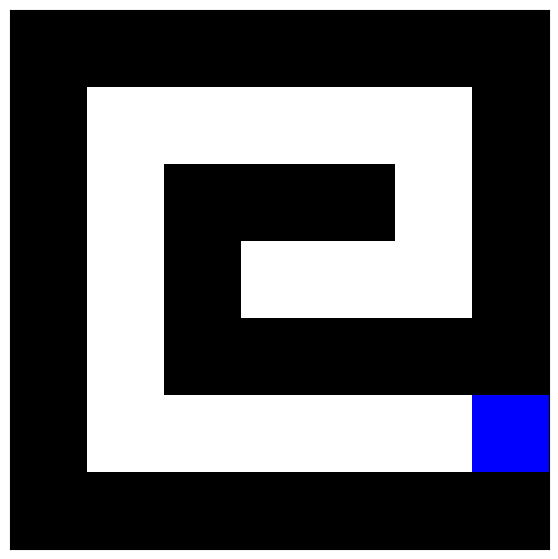

In [9]:
def test_agent(agent, game, max_steps=50):
    game.initialPosition(3, 3)  # Reset to starting position
    state = game.current_pos
    steps = 0
    success = False
    # Display the initial state of the maze
    # game.plot()
    print(f"Starting test from position: {state}")
    while not success and steps < max_steps:
        state_index = agent.state_to_index(state)
        action = agent.actions[np.argmax(agent.q_table[state_index])]  # Choose best action
        success = game.makeMove(action)  # Perform the action
        state = game.current_pos  # Update state
        steps += 1
        print(f"Step {steps}: Moved {action}, New position: {state}")
    if success:
        print("Success! The agent found the way out.")
    else:
        print("Failed to find the way out within the maximum allowed steps.")

    # Display the final state of the maze
    game.plot()
# Now, let's test the trained agent.
test_agent(agent, maze_game)

## LogScale Experiment

In [10]:
def test_agent_for_log_scale_experiment(agent_for_test, game, max_steps=50):
    game.initialPosition(3, 3)  # Reset to starting position
    state = game.current_pos
    steps = 0
    success = False
    while not success and steps < max_steps:
        state_index = agent_for_test.state_to_index(state)
        action = agent_for_test.actions[np.argmax(agent_for_test.q_table[state_index])]  # Choose best action
        success = game.makeMove(action)  # Perform the action
        state = game.current_pos  # Update state
        steps += 1
    if success:
        return 1
    else:
        return 0

In [11]:
def experiment(maze_game, log_scale=1, num_agents=10):
    train_episode = 10**log_scale
    print('Training Trials for each agent:', train_episode)
    success_agents = 0
    for _ in range(num_agents):
        agent_for_experiment = QLearningAgent_with_noisy_punishment(maze_game)
        agent_for_experiment.train(train_episode, False)
        successes = test_agent_for_log_scale_experiment(agent_for_experiment, maze_game)
        if successes:
            success_agents = success_agents + 1
    average_success_percentage = success_agents/num_agents
    print('The successfully navigated agents:', success_agents)
    print(f"Average success percentage across {num_agents} agents: {average_success_percentage*100:.2f}%")

In [12]:
experiment(maze_game, 1)

Training Trials for each agent: 10
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
The successfully navigated agents: 0
Average success percentage across 10 agents: 0.00%


In [13]:
experiment(maze_game, 2)

Training Trials for each agent: 100
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
The successfully navigated agents: 0
Average success percentage across 10 agents: 0.00%


In [14]:
experiment(maze_game, 3)

Training Trials for each agent: 1000
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
The successfully navigated agents: 0
Average success percentage across 10 agents: 0.00%


In [15]:
experiment(maze_game, 4)

Training Trials for each agent: 10000
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
The successfully navigated agents: 0
Average success percentage across 10 agents: 0.00%


In [16]:
experiment(maze_game, 5)

Training Trials for each agent: 100000
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
in Episode 0: the agent completed in 50 steps.
The successfully navigated agents: 3
Average success percentage across 10 agents: 0.30%


In [ ]:
experiment(maze_game, 6)

Training Trials for each agent: 1000000
in Episode 0: the agent completed in 50 steps.
in Episode 100000: the agent completed in 50 steps.
in Episode 200000: the agent completed in 50 steps.
in Episode 300000: the agent completed in 50 steps.


In [ ]:
experiment(maze_game, 7)